문제1-1
_01_code/_18_lstm_and_its_application/g_crypto_currency_regression_train_lstm.py 실행 결과

In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from datetime import datetime
import os
import wandb
from pathlib import Path

BASE_PATH = str(Path().resolve().parent.parent) 
import sys
sys.path.append(BASE_PATH)

CURRENT_FILE_PATH = os.getcwd()
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")

if not os.path.isdir(CHECKPOINT_FILE_PATH):
  os.makedirs(os.path.join(CURRENT_FILE_PATH, "checkpoints"))

from f_arg_parser import get_parser
from g_rnn_trainer import RegressionTrainer
from p__cryptocurrency_dataset_dataloader import get_cryptocurrency_data, \
  CryptoCurrencyDataset


def get_btc_krw_data(sequence_size=21, validation_size=150, test_size=30, is_regression=True):
  X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date \
    = get_cryptocurrency_data(
      sequence_size=sequence_size, validation_size=validation_size, test_size=test_size,
      target_column='Close', y_normalizer=1.0e7, is_regression=is_regression
  )

  train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train)
  validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation)
  test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test)

  train_data_loader = DataLoader(
    dataset=train_crypto_currency_dataset, batch_size=wandb.config.batch_size, shuffle=True
  )
  validation_data_loader = DataLoader(
    dataset=validation_crypto_currency_dataset, batch_size=wandb.config.batch_size, shuffle=True
  )
  test_data_loader = DataLoader(
    dataset=test_crypto_currency_dataset, batch_size=len(test_crypto_currency_dataset), shuffle=True
  )

  return train_data_loader, validation_data_loader, test_data_loader


def get_model():
  class MyModel(nn.Module):
    def __init__(self, n_input, n_output):
      super().__init__()

      self.lstm = nn.LSTM(input_size=n_input, hidden_size=128, num_layers=2, batch_first=True)
      self.fcn = nn.Linear(in_features=128, out_features=n_output)

    def forward(self, x):
      x, hidden = self.lstm(x)
      x = x[:, -1, :]  
      x = self.fcn(x)
      return x

  my_model = MyModel(n_input=5, n_output=1)

  return my_model


def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,
    'early_stop_patience': args.early_stop_patience,
    'early_stop_delta': args.early_stop_delta,
    'weight_decay': args.weight_decay
  }

  project_name = "lstm_regression_btc_krw"
  wandb.init(
    mode="online",
    project=project_name,
    notes="btc_krw experiment with lstm",
    tags=["lstm", "regression", "btc_krw"],
    name=run_time_str,
    config=config
  )
  print(args)
  print(wandb.config)

  train_data_loader, validation_data_loader, _ = get_btc_krw_data()
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  print(f"Training on device {device}.")

  model = get_model()
  model.to(device)

  optimizer = optim.Adam(model.parameters(), lr=wandb.config.learning_rate, weight_decay=wandb.config.weight_decay)

  regression_trainer = RegressionTrainer(
    project_name, model, optimizer, train_data_loader, validation_data_loader, None,
    run_time_str, wandb, device, CHECKPOINT_FILE_PATH
  )
  regression_trainer.train_loop()

  wandb.finish()


if __name__ == "__main__":
  parser = get_parser()
  args = parser.parse_args([])
  main(args)

wandb: Currently logged in as: seongjh1105 (seongjh1105-korea-university-of-technology-and-education) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Namespace(wandb=True, batch_size=2048, epochs=10000, learning_rate=0.0001, weight_decay=0, validation_intervals=30, early_stop_patience=30, early_stop_delta=1e-06)
{'epochs': 10000, 'batch_size': 2048, 'validation_intervals': 30, 'learning_rate': 0.0001, 'early_stop_patience': 30, 'early_stop_delta': 1e-06, 'weight_decay': 0}
Training on device cuda:0.
[Epoch   1] T_loss: 5.98849, V_loss: 13.12674, Early stopping is stated! | T_time: 00:00:00, T_speed: 0.000
[Epoch  30] T_loss: 2.58404, V_loss: 5.49312, V_loss decreased (13.12674 --> 5.49312). Saving model... | T_time: 00:00:01, T_speed: 30.000
[Epoch  60] T_loss: 0.27045, V_loss: 0.05032, V_loss decreased (5.49312 --> 0.05032). Saving model... | T_time: 00:00:03, T_speed: 20.000
[Epoch  90] T_loss: 0.11383, V_loss: 0.02877, V_loss decreased (0.05032 --> 0.02877). Saving model... | T_time: 00:00:04, T_speed: 22.500
[Epoch 120] T_loss: 0.07549, V_loss: 0.02261, V_loss decreased (0.02877 --> 0.02261). Saving model... | T_time: 00:00:06, 

Epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇███
Training loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training speed (epochs/sec.),▁█▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
Validation loss,█▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,1830
Training loss,0.01072
Training speed (epochs/sec.),20.5618
Validation loss,0.01426


문제1-2
_01_code/_18_lstm_and_its_application/h_crypto_currency_regression_test_lstm.py 실행 결과

MODEL FILE: /home/kroad/Downloads/git/link_dl/_04_your_code/checkpoints/lstm_regression_btc_krw_checkpoint_latest.pt


/tmp/ipykernel_151774/3507332742.py:121: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_model.load_state_dict(torch.load(latest_file_path, map_location=torch.device('cpu

[TEST DATA]
 0: 377.38 <--> 369.19 (Loss:          8.20)
 1: 469.48 <--> 464.58 (Loss:          4.90)
 2: 364.37 <--> 363.46 (Loss:          0.91)
 3: 383.95 <--> 389.72 (Loss:          5.77)
 4: 375.86 <--> 371.69 (Loss:          4.17)
 5: 446.43 <--> 461.57 (Loss:         15.15)
 6: 462.01 <--> 459.89 (Loss:          2.12)
 7: 412.44 <--> 455.68 (Loss:         43.24)
 8: 469.64 <--> 462.33 (Loss:          7.31)
 9: 364.34 <--> 384.49 (Loss:         20.15)
10: 377.23 <--> 383.94 (Loss:          6.71)
11: 402.97 <--> 444.08 (Loss:         41.11)
12: 371.15 <--> 361.07 (Loss:         10.09)
13: 375.70 <--> 367.74 (Loss:          7.97)
14: 369.75 <--> 384.58 (Loss:         14.83)
15: 393.40 <--> 404.00 (Loss:         10.60)
16: 376.10 <--> 376.00 (Loss:          0.10)
17: 366.99 <--> 363.47 (Loss:          3.53)
18: 471.07 <--> 468.41 (Loss:          2.66)
19: 374.47 <--> 359.80 (Loss:         14.67)
20: 373.32 <--> 373.07 (Loss:          0.25)
21: 427.73 <--> 466.85 (Loss:         39.12

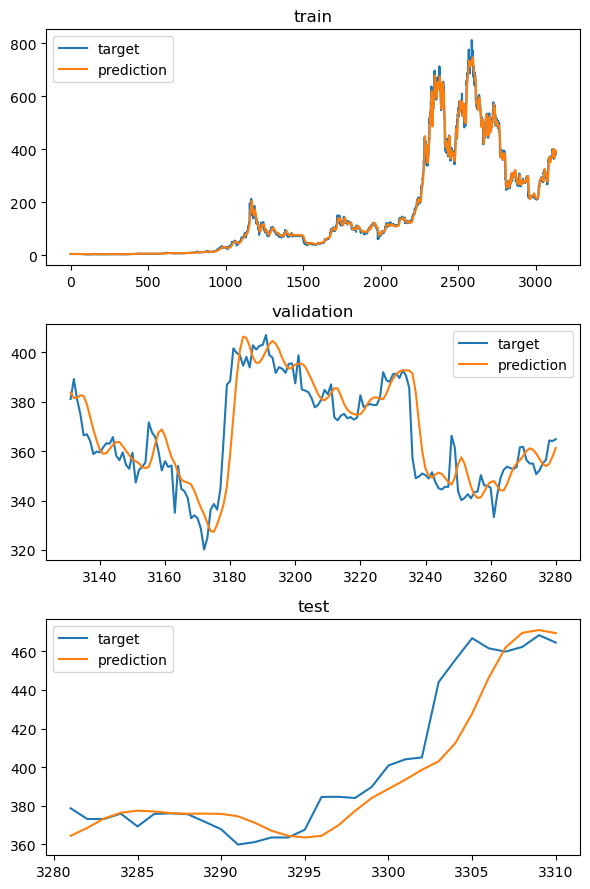

In [2]:
import torch
import wandb
from matplotlib import pyplot as plt
from datetime import datetime
import os
from pathlib import Path


BASE_PATH = str(Path().resolve().parent.parent) 
import sys
sys.path.append(BASE_PATH)

CURRENT_FILE_PATH = os.getcwd()
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")
if not os.path.isdir(CHECKPOINT_FILE_PATH):
  os.makedirs(os.path.join(CURRENT_FILE_PATH, "checkpoints"))

from f_arg_parser import get_parser
from p__cryptocurrency_dataset_dataloader import get_cryptocurrency_data, \
  CryptoCurrencyDataset
from g_crypto_currency_regression_train_lstm import get_model, get_btc_krw_data


def test(test_model):
  _, _, test_data_loader = get_btc_krw_data()

  test_model.eval()

  y_normalizer = 100

  print("[TEST DATA]")
  with torch.no_grad():
    for test_batch in test_data_loader:
      input_test, target_test = test_batch

      output_test = test_model(input_test)

    for idx, (output, target) in enumerate(zip(output_test, target_test)):
      print("{0:2}: {1:6,.2f} <--> {2:6,.2f} (Loss: {3:>13,.2f})".format(
        idx,
        output.item() * y_normalizer,
        target.item() * y_normalizer,
        abs(output.squeeze(dim=-1).item() - target.item()) * y_normalizer
      ))


def predict_all(test_model):
  y_normalizer = 100

  X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date \
    = get_cryptocurrency_data(
      sequence_size=21, validation_size=150, test_size=30,
      target_column='Close', y_normalizer=1.0e7, is_regression=True
  )

  train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train)
  validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation)
  test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test)

  dataset_list = [
    train_crypto_currency_dataset, validation_crypto_currency_dataset, test_crypto_currency_dataset
  ]
  dataset_labels = [
    "train", "validation", "test"
  ]
  num = 0
  fig, axs = plt.subplots(3, 1, figsize=(6, 9))

  for i in range(3):
    X = []
    TARGET_Y = []
    PREDICTION_Y = []
    for data in dataset_list[i]:
      input, target = data
      prediction = test_model(input.unsqueeze(0)).squeeze(-1).squeeze(-1)

      X.append(num)
      TARGET_Y.append(target.item() * y_normalizer)
      PREDICTION_Y.append(prediction.item() * y_normalizer)

      num += 1

    axs[i].plot(X, TARGET_Y, label='target')
    axs[i].plot(X, PREDICTION_Y, label='prediction')
    axs[i].set_title(dataset_labels[i])
    axs[i].legend()

  plt.tight_layout()
  plt.show()


def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,
    'early_stop_patience': args.early_stop_patience,
    'early_stop_delta': args.early_stop_delta,
  }

  project_name = "lstm_regression_btc_krw"
  wandb.init(
    mode="disabled",
    project=project_name,
    notes="btc_krw experiment with lstm",
    tags=["lstm", "regression", "btc_krw"],
    name=run_time_str,
    config=config
  )

  test_model = get_model()

  project_name = "lstm_regression_btc_krw"
  latest_file_path = os.path.join(
    CHECKPOINT_FILE_PATH, f"{project_name}_checkpoint_latest.pt"
  )
  print("MODEL FILE: {0}".format(latest_file_path))
  test_model.load_state_dict(torch.load(latest_file_path, map_location=torch.device('cpu')))

  test(test_model)
  predict_all(test_model)


if __name__ == "__main__":
  parser = get_parser()
  args = parser.parse_args([])
  main(args)

문제1-3
_01_code/_18_lstm_and_its_application/i_crypto_currency_classification_train_lstm.py 실행 결과

In [1]:
import torch
from torch import nn, optim
from datetime import datetime
import os
import wandb
from pathlib import Path

BASE_PATH = str(Path().resolve().parent.parent) 
import sys
sys.path.append(BASE_PATH)

CURRENT_FILE_PATH = os.getcwd()
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")

if not os.path.isdir(CHECKPOINT_FILE_PATH):
  os.makedirs(os.path.join(CURRENT_FILE_PATH, "checkpoints"))

from c_trainer import ClassificationTrainer
from f_arg_parser import get_parser
from g_crypto_currency_regression_train_lstm import get_btc_krw_data


def get_model():
  class MyModel(nn.Module):
    def __init__(self, n_input, n_output):
      super().__init__()

      self.lstm = nn.LSTM(input_size=n_input, hidden_size=256, num_layers=3, batch_first=True)
      self.fcn = nn.Linear(in_features=256, out_features=n_output)

    def forward(self, x):
      x, hidden = self.lstm(x)
      x = x[:, -1, :]  
      x = self.fcn(x)
      return x

  my_model = MyModel(n_input=5, n_output=2)

  return my_model


def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,
    'early_stop_patience': args.early_stop_patience,
    'early_stop_delta': args.early_stop_delta,
    'weight_decay': args.weight_decay
  }

  project_name = "lstm_classification_btc_krw"
  wandb.init(
    mode="online",
    project=project_name,
    notes="btc_krw experiment with lstm",
    tags=["lstm", "classification", "btc_krw"],
    name=run_time_str,
    config=config
  )
  print(args)
  print(wandb.config)

  train_data_loader, validation_data_loader, _ = get_btc_krw_data(is_regression=False)
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  print(f"Training on device {device}.")

  model = get_model()
  model.to(device)

  optimizer = optim.Adam(model.parameters(), lr=wandb.config.learning_rate, weight_decay=wandb.config.weight_decay)

  classification_trainer = ClassificationTrainer(
    project_name, model, optimizer, train_data_loader, validation_data_loader, None,
    run_time_str, wandb, device, CHECKPOINT_FILE_PATH
  )
  classification_trainer.train_loop()

  wandb.finish()


if __name__ == "__main__":
  parser = get_parser()
  args = parser.parse_args([])
  main(args)


wandb: Currently logged in as: seongjh1105 (seongjh1105-korea-university-of-technology-and-education) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Namespace(wandb=True, batch_size=2048, epochs=10000, learning_rate=0.0001, weight_decay=0, validation_intervals=30, early_stop_patience=30, early_stop_delta=1e-06)
{'epochs': 10000, 'batch_size': 2048, 'validation_intervals': 30, 'learning_rate': 0.0001, 'early_stop_patience': 30, 'early_stop_delta': 1e-06, 'weight_decay': 0}
Training on device cuda:0.
[Epoch   1] T_loss: 0.69176, T_accuracy: 53.0182 | V_loss: 0.69727, V_accuracy: 47.3333 | Early stopping is stated! | T_time: 00:00:00, T_speed: 0.000
[Epoch  30] T_loss: 0.68951, T_accuracy: 53.3695 | V_loss: 0.69397, V_accuracy: 47.3333 | V_loss decreased (0.69727 --> 0.69397). Saving model... | T_time: 00:00:03, T_speed: 10.000
[Epoch  60] T_loss: 0.69011, T_accuracy: 53.3376 | V_loss: 0.69393, V_accuracy: 47.3333 | V_loss decreased (0.69397 --> 0.69393). Saving model... | T_time: 00:00:06, T_speed: 10.000
[Epoch  90] T_loss: 0.68894, T_accuracy: 53.4334 | V_loss: 0.69378, V_accuracy: 47.3333 | V_loss decreased (0.69393 --> 0.69378). 

Epoch,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
Training accuracy (%),▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▄▄▅▄▄▅▅▆▇▆▆▆▇▇▇█▇▇
Training loss,█▇▇▇▇▇▇▇▇▇▇▆▆▆▅▅▄▅▄▅▄▄▃▄▃▄▃▃▂▂▂▁▃▂
Training speed (epochs/sec.),▁█████████████████████████████████
Validation accuracy (%),▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█
Validation loss,▃▁▁▁▁▁▂▂▂▂▂▂▁▂▁▁▁▁▁▁▂▂▂▂▂▃▃▃▄▄▅▅█▅
Epoch,990
Training accuracy (%),55.9885
Training loss,0.67205
Training speed (epochs/sec.),10.10204
Validation accuracy (%),48


문제1-4
_01_code/_18_lstm_and_its_application/j_crypto_currency_classification_test_lstm.py 실행 결과

In [2]:
import torch
import os
from pathlib import Path
from datetime import datetime
import wandb


BASE_PATH = str(Path().resolve().parent.parent) 
import sys
sys.path.append(BASE_PATH)

CURRENT_FILE_PATH = os.getcwd()
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")

if not os.path.isdir(CHECKPOINT_FILE_PATH):
  os.makedirs(os.path.join(CURRENT_FILE_PATH, "checkpoints"))

from f_arg_parser import get_parser
from g_crypto_currency_regression_train_lstm import get_btc_krw_data
from i_crypto_currency_classification_train_lstm import get_model


def test(test_model):
  _, _, test_data_loader = get_btc_krw_data(is_regression=False)

  test_model.eval()

  num_corrects_test = 0
  num_tested_samples = 0

  print("[TEST DATA]")
  with torch.no_grad():
    for test_batch in test_data_loader:
      input_test, target_test = test_batch

      output_test = test_model(input_test)

      predicted_test = torch.argmax(output_test, dim=1)
      num_corrects_test += torch.sum(torch.eq(predicted_test, target_test))

      num_tested_samples += len(input_test)

    test_accuracy = 100.0 * num_corrects_test / num_tested_samples

    print(f"TEST RESULTS: {test_accuracy:6.3f}%")

    for idx, (output, target) in enumerate(zip(output_test, target_test)):
      print("{0:2}: {1:6,.2f} <--> {2:6,.2f}".format(
        idx, torch.argmax(output).item(), target.item()
      ))


def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,
    'early_stop_patience': args.early_stop_patience,
    'early_stop_delta': args.early_stop_delta,
  }

  project_name = "lstm_classification_btc_krw"
  wandb.init(
    mode="disabled",
    project=project_name,
    notes="btc_krw experiment with lstm",
    tags=["lstm", "regression", "btc_krw"],
    name=run_time_str,
    config=config
  )

  test_model = get_model()

  latest_file_path = os.path.join(
    CHECKPOINT_FILE_PATH, f"{project_name}_checkpoint_latest.pt"
  )
  print("MODEL FILE: {0}".format(latest_file_path))
  test_model.load_state_dict(torch.load(latest_file_path, map_location=torch.device('cpu')))

  test(test_model)


if __name__ == "__main__":
  parser = get_parser()
  args = parser.parse_args([])
  main(args)


MODEL FILE: /home/kroad/Downloads/git/link_dl/_04_your_code/checkpoints/lstm_classification_btc_krw_checkpoint_latest.pt


/tmp/ipykernel_156205/1361066133.py:81: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_model.load_state_dict(torch.load(latest_file_path, map_location=torch.device('cpu'

[TEST DATA]
TEST RESULTS: 66.667%
 0:   1.00 <-->   1.00
 1:   0.00 <-->   0.00
 2:   1.00 <-->   1.00
 3:   0.00 <-->   0.00
 4:   1.00 <-->   1.00
 5:   0.00 <-->   1.00
 6:   1.00 <-->   0.00
 7:   1.00 <-->   0.00
 8:   1.00 <-->   0.00
 9:   1.00 <-->   1.00
10:   1.00 <-->   1.00
11:   1.00 <-->   1.00
12:   1.00 <-->   1.00
13:   1.00 <-->   1.00
14:   1.00 <-->   1.00
15:   1.00 <-->   1.00
16:   1.00 <-->   1.00
17:   1.00 <-->   0.00
18:   1.00 <-->   0.00
19:   0.00 <-->   1.00
20:   1.00 <-->   1.00
21:   1.00 <-->   1.00
22:   1.00 <-->   1.00
23:   1.00 <-->   1.00
24:   1.00 <-->   0.00
25:   1.00 <-->   1.00
26:   1.00 <-->   0.00
27:   1.00 <-->   1.00
28:   0.00 <-->   0.00
29:   1.00 <-->   0.00


문제2-1
파라미터 수정 후
_01_code/_18_lstm_and_its_application/g_crypto_currency_regression_train_lstm.py 실행 결과
및
_01_code/_18_lstm_and_its_application/
h_crypto_currency_regression_test_lstm.py 실행 결과

In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from datetime import datetime
import os
import wandb
from pathlib import Path

BASE_PATH = str(Path().resolve().parent.parent) 
import sys
sys.path.append(BASE_PATH)

CURRENT_FILE_PATH = os.getcwd()
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")

if not os.path.isdir(CHECKPOINT_FILE_PATH):
  os.makedirs(os.path.join(CURRENT_FILE_PATH, "checkpoints"))

from f_arg_parser import get_parser
from g_rnn_trainer import RegressionTrainer
from p__cryptocurrency_dataset_dataloader import get_cryptocurrency_data, \
  CryptoCurrencyDataset


def get_btc_krw_data(sequence_size=21, validation_size=150, test_size=30, is_regression=True):
  X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date \
    = get_cryptocurrency_data(
      sequence_size=sequence_size, validation_size=validation_size, test_size=test_size,
      target_column='Close', y_normalizer=1.0e7, is_regression=is_regression
  )

  train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train)
  validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation)
  test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test)

  train_data_loader = DataLoader(
    dataset=train_crypto_currency_dataset, batch_size=wandb.config.batch_size, shuffle=True
  )
  validation_data_loader = DataLoader(
    dataset=validation_crypto_currency_dataset, batch_size=wandb.config.batch_size, shuffle=True
  )
  test_data_loader = DataLoader(
    dataset=test_crypto_currency_dataset, batch_size=len(test_crypto_currency_dataset), shuffle=True
  )

  return train_data_loader, validation_data_loader, test_data_loader


def get_model():
  class MyModel(nn.Module):
    def __init__(self, n_input, n_output):
      super().__init__()

      self.lstm = nn.LSTM(input_size=n_input, hidden_size=128, num_layers=2, batch_first=True, dropout=0.1)
      self.fcn = nn.Linear(in_features=128, out_features=n_output)

    def forward(self, x):
      x, hidden = self.lstm(x)
      x = x[:, -1, :]  
      x = self.fcn(x)
      return x

  my_model = MyModel(n_input=5, n_output=1)

  return my_model


def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,
    'early_stop_patience': args.early_stop_patience,
    'early_stop_delta': args.early_stop_delta,
    'weight_decay': args.weight_decay
  }

  project_name = "lstm_regression_btc_krw"
  wandb.init(
    mode="online",
    project=project_name,
    notes="btc_krw experiment with lstm",
    tags=["lstm", "regression", "btc_krw"],
    name=run_time_str,
    config=config
  )
  print(args)
  print(wandb.config)

  train_data_loader, validation_data_loader, _ = get_btc_krw_data()
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  print(f"Training on device {device}.")

  model = get_model()
  model.to(device)

  optimizer = optim.Adam(model.parameters(), lr=wandb.config.learning_rate, weight_decay=1e-3)

  regression_trainer = RegressionTrainer(
    project_name, model, optimizer, train_data_loader, validation_data_loader, None,
    run_time_str, wandb, device, CHECKPOINT_FILE_PATH
  )
  regression_trainer.train_loop()

  wandb.finish()


if __name__ == "__main__":
  parser = get_parser()
  args = parser.parse_args([])
  main(args)

wandb: Currently logged in as: seongjh1105 (seongjh1105-korea-university-of-technology-and-education) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Namespace(wandb=True, batch_size=2048, epochs=10000, learning_rate=0.0001, weight_decay=0, validation_intervals=30, early_stop_patience=30, early_stop_delta=1e-06)
{'epochs': 10000, 'batch_size': 2048, 'validation_intervals': 30, 'learning_rate': 0.0001, 'early_stop_patience': 30, 'early_stop_delta': 1e-06, 'weight_decay': 0}
Training on device cuda:0.
[Epoch   1] T_loss: 5.96989, V_loss: 13.15258, Early stopping is stated! | T_time: 00:00:00, T_speed: 0.000
[Epoch  30] T_loss: 3.07905, V_loss: 6.42933, V_loss decreased (13.15258 --> 6.42933). Saving model... | T_time: 00:00:01, T_speed: 30.000
[Epoch  60] T_loss: 0.28607, V_loss: 0.08125, V_loss decreased (6.42933 --> 0.08125). Saving model... | T_time: 00:00:03, T_speed: 20.000
[Epoch  90] T_loss: 0.13554, V_loss: 0.03944, V_loss decreased (0.08125 --> 0.03944). Saving model... | T_time: 00:00:04, T_speed: 22.500
[Epoch 120] T_loss: 0.08909, V_loss: 0.02426, V_loss decreased (0.03944 --> 0.02426). Saving model... | T_time: 00:00:06, 

Epoch,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
Training loss,█▇▅▅▅▅▄▃▃▃▂▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training speed (epochs/sec.),▁▇█▇▅▅▆▅▅▄▄▄▄▃▃▄▄▄▄▄▄▄▄▄▃▄▃▃▂▃▂▂▂▂▂▂▂▂▂▂
Validation loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,9540
Training loss,0.01033
Training speed (epochs/sec.),20.08421
Validation loss,0.00591


MODEL FILE: /home/kroad/Downloads/git/link_dl/_04_your_code/checkpoints/lstm_regression_btc_krw_checkpoint_latest.pt


/tmp/ipykernel_162899/3507332742.py:121: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_model.load_state_dict(torch.load(latest_file_path, map_location=torch.device('cpu

[TEST DATA]
 0: 373.72 <--> 367.74 (Loss:          5.98)
 1: 372.96 <--> 375.70 (Loss:          2.74)
 2: 396.88 <--> 404.00 (Loss:          7.12)
 3: 362.79 <--> 367.49 (Loss:          4.70)
 4: 465.18 <--> 464.58 (Loss:          0.61)
 5: 384.24 <--> 383.94 (Loss:          0.30)
 6: 360.38 <--> 363.47 (Loss:          3.09)
 7: 363.57 <--> 361.07 (Loss:          2.50)
 8: 375.15 <--> 375.55 (Loss:          0.40)
 9: 365.45 <--> 384.49 (Loss:         19.04)
10: 372.37 <--> 373.05 (Loss:          0.68)
11: 402.53 <--> 405.02 (Loss:          2.49)
12: 466.24 <--> 459.89 (Loss:          6.35)
13: 376.77 <--> 373.07 (Loss:          3.71)
14: 362.14 <--> 363.46 (Loss:          1.32)
15: 386.10 <--> 389.72 (Loss:          3.62)
16: 375.11 <--> 375.84 (Loss:          0.73)
17: 364.98 <--> 378.60 (Loss:         13.62)
18: 465.73 <--> 461.57 (Loss:          4.15)
19: 404.97 <--> 444.08 (Loss:         39.11)
20: 375.49 <--> 371.69 (Loss:          3.80)
21: 379.16 <--> 384.58 (Loss:          5.42

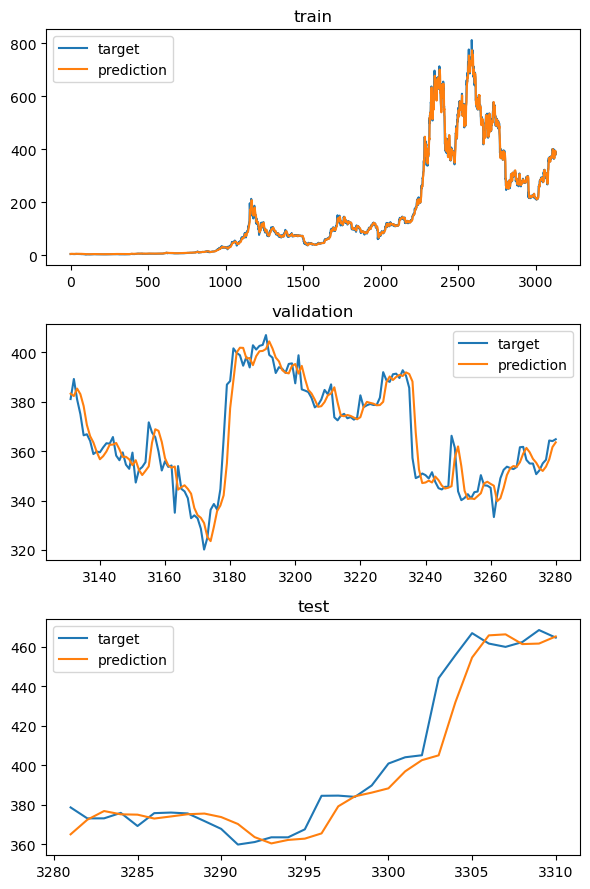

In [2]:
import torch
import wandb
from matplotlib import pyplot as plt
from datetime import datetime
import os
from pathlib import Path


BASE_PATH = str(Path().resolve().parent.parent) 
import sys
sys.path.append(BASE_PATH)

CURRENT_FILE_PATH = os.getcwd()
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")
if not os.path.isdir(CHECKPOINT_FILE_PATH):
  os.makedirs(os.path.join(CURRENT_FILE_PATH, "checkpoints"))

from f_arg_parser import get_parser
from p__cryptocurrency_dataset_dataloader import get_cryptocurrency_data, \
  CryptoCurrencyDataset
from g_crypto_currency_regression_train_lstm import get_model, get_btc_krw_data


def test(test_model):
  _, _, test_data_loader = get_btc_krw_data()

  test_model.eval()

  y_normalizer = 100

  print("[TEST DATA]")
  with torch.no_grad():
    for test_batch in test_data_loader:
      input_test, target_test = test_batch

      output_test = test_model(input_test)

    for idx, (output, target) in enumerate(zip(output_test, target_test)):
      print("{0:2}: {1:6,.2f} <--> {2:6,.2f} (Loss: {3:>13,.2f})".format(
        idx,
        output.item() * y_normalizer,
        target.item() * y_normalizer,
        abs(output.squeeze(dim=-1).item() - target.item()) * y_normalizer
      ))


def predict_all(test_model):
  y_normalizer = 100

  X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date \
    = get_cryptocurrency_data(
      sequence_size=21, validation_size=150, test_size=30,
      target_column='Close', y_normalizer=1.0e7, is_regression=True
  )

  train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train)
  validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation)
  test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test)

  dataset_list = [
    train_crypto_currency_dataset, validation_crypto_currency_dataset, test_crypto_currency_dataset
  ]
  dataset_labels = [
    "train", "validation", "test"
  ]
  num = 0
  fig, axs = plt.subplots(3, 1, figsize=(6, 9))

  for i in range(3):
    X = []
    TARGET_Y = []
    PREDICTION_Y = []
    for data in dataset_list[i]:
      input, target = data
      prediction = test_model(input.unsqueeze(0)).squeeze(-1).squeeze(-1)

      X.append(num)
      TARGET_Y.append(target.item() * y_normalizer)
      PREDICTION_Y.append(prediction.item() * y_normalizer)

      num += 1

    axs[i].plot(X, TARGET_Y, label='target')
    axs[i].plot(X, PREDICTION_Y, label='prediction')
    axs[i].set_title(dataset_labels[i])
    axs[i].legend()

  plt.tight_layout()
  plt.show()


def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,
    'early_stop_patience': args.early_stop_patience,
    'early_stop_delta': args.early_stop_delta,
  }

  project_name = "lstm_regression_btc_krw"
  wandb.init(
    mode="disabled",
    project=project_name,
    notes="btc_krw experiment with lstm",
    tags=["lstm", "regression", "btc_krw"],
    name=run_time_str,
    config=config
  )

  test_model = get_model()

  project_name = "lstm_regression_btc_krw"
  latest_file_path = os.path.join(
    CHECKPOINT_FILE_PATH, f"{project_name}_checkpoint_latest.pt"
  )
  print("MODEL FILE: {0}".format(latest_file_path))
  test_model.load_state_dict(torch.load(latest_file_path, map_location=torch.device('cpu')))

  test(test_model)
  predict_all(test_model)


if __name__ == "__main__":
  parser = get_parser()
  args = parser.parse_args([])
  main(args)

lstm layer 수 : 2개
linear layer 수 : 1개
weight decay : 1e-3
dropout rate : 0.1

문제 1번에서는 다음과 같이 loss가 분포되었다.
최대 : 43.24
최소 : 0.10
평균 : 10.23
표준 편차 : 11.54

문제 2에서는 다음과 같이 loss가 분포되었다.
최대 : 39.11
최소 : 0.30
평균 : 6.87
표준 편차: : 8.17

문제 2에서는 평균이 많이 감소했고 표준편차 또한 많이 감소하였다.

문제2-2
파라미터 수정 후
 _01_code/_18_lstm_and_its_application/i_crypto_currency_classification_train_lstm.py 실행 결과
 및
_01_code/_18_lstm_and_its_application/j_crypto_currency_classification_test_lstm.py 실행 결과

In [3]:
import torch
from torch import nn, optim
from datetime import datetime
import os
import wandb
from pathlib import Path

BASE_PATH = str(Path().resolve().parent.parent) 
import sys
sys.path.append(BASE_PATH)

CURRENT_FILE_PATH = os.getcwd()
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")

if not os.path.isdir(CHECKPOINT_FILE_PATH):
  os.makedirs(os.path.join(CURRENT_FILE_PATH, "checkpoints"))

from c_trainer import ClassificationTrainer
from f_arg_parser import get_parser
from g_crypto_currency_regression_train_lstm import get_btc_krw_data


def get_model():
  class MyModel(nn.Module):
    def __init__(self, n_input, n_output):
      super().__init__()

      self.lstm = nn.LSTM(input_size=n_input, hidden_size=256, num_layers=3, batch_first=True, dropout=0.1)
      self.fcn = nn.Linear(in_features=256, out_features=n_output)

    def forward(self, x):
      x, hidden = self.lstm(x)
      x = x[:, -1, :]  
      x = self.fcn(x)
      return x

  my_model = MyModel(n_input=5, n_output=2)

  return my_model


def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,
    'early_stop_patience': args.early_stop_patience,
    'early_stop_delta': args.early_stop_delta,
    'weight_decay': args.weight_decay
  }

  project_name = "lstm_classification_btc_krw"
  wandb.init(
    mode="online",
    project=project_name,
    notes="btc_krw experiment with lstm",
    tags=["lstm", "classification", "btc_krw"],
    name=run_time_str,
    config=config
  )
  print(args)
  print(wandb.config)

  train_data_loader, validation_data_loader, _ = get_btc_krw_data(is_regression=False)
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  print(f"Training on device {device}.")

  model = get_model()
  model.to(device)

  optimizer = optim.Adam(model.parameters(), lr=wandb.config.learning_rate, weight_decay=0)

  classification_trainer = ClassificationTrainer(
    project_name, model, optimizer, train_data_loader, validation_data_loader, None,
    run_time_str, wandb, device, CHECKPOINT_FILE_PATH
  )
  classification_trainer.train_loop()

  wandb.finish()


if __name__ == "__main__":
  parser = get_parser()
  args = parser.parse_args([])
  main(args)

Namespace(wandb=True, batch_size=2048, epochs=10000, learning_rate=0.0001, weight_decay=0, validation_intervals=30, early_stop_patience=30, early_stop_delta=1e-06)
{'epochs': 10000, 'batch_size': 2048, 'validation_intervals': 30, 'learning_rate': 0.0001, 'early_stop_patience': 30, 'early_stop_delta': 1e-06, 'weight_decay': 0}
Training on device cuda:0.
[Epoch   1] T_loss: 0.69214, T_accuracy: 53.0182 | V_loss: 0.69506, V_accuracy: 47.3333 | Early stopping is stated! | T_time: 00:00:00, T_speed: 0.000
[Epoch  30] T_loss: 0.69016, T_accuracy: 53.5931 | V_loss: 0.69375, V_accuracy: 47.3333 | V_loss decreased (0.69506 --> 0.69375). Saving model... | T_time: 00:00:03, T_speed: 10.000
[Epoch  60] T_loss: 0.69056, T_accuracy: 53.2098 | V_loss: 0.69369, V_accuracy: 47.3333 | V_loss decreased (0.69375 --> 0.69369). Saving model... | T_time: 00:00:06, T_speed: 10.000
[Epoch  90] T_loss: 0.69023, T_accuracy: 53.4015 | V_loss: 0.69402, V_accuracy: 47.3333 | Early stopping counter: 1 out of 30 | T_

Epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Training accuracy (%),▁▂▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▅▆▇▇▇██
Training loss,███████████▇▇▇▇▇▇▇▇▇▇▇▆▆▆▅▆▅▅▅▄▄▄▃▃▂▂▂▂▁
Training speed (epochs/sec.),▁███████████████████████████████████████
Validation accuracy (%),▃▃▃▃▃▃▃▃▃▃▃█▃▃▃▁▃▃▅▃▃▃▃▃▃▃▃▃▃▃▃▃▃▅▄▄▄▄▄▅
Validation loss,▂▁▁▁▁▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▂▂▂▂▂▂▃▂▃▆▅▆▃▆▇▆██▇
Epoch,1410
Training accuracy (%),60.81124
Training loss,0.61311
Training speed (epochs/sec.),9.4
Validation accuracy (%),48.66667


In [1]:
import torch
import os
from pathlib import Path
from datetime import datetime
import wandb


BASE_PATH = str(Path().resolve().parent.parent) 
import sys
sys.path.append(BASE_PATH)

CURRENT_FILE_PATH = os.getcwd()
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")

if not os.path.isdir(CHECKPOINT_FILE_PATH):
  os.makedirs(os.path.join(CURRENT_FILE_PATH, "checkpoints"))

from f_arg_parser import get_parser
from g_crypto_currency_regression_train_lstm import get_btc_krw_data
from i_crypto_currency_classification_train_lstm import get_model


def test(test_model):
  _, _, test_data_loader = get_btc_krw_data(is_regression=False)

  test_model.eval()

  num_corrects_test = 0
  num_tested_samples = 0

  print("[TEST DATA]")
  with torch.no_grad():
    for test_batch in test_data_loader:
      input_test, target_test = test_batch

      output_test = test_model(input_test)

      predicted_test = torch.argmax(output_test, dim=1)
      num_corrects_test += torch.sum(torch.eq(predicted_test, target_test))

      num_tested_samples += len(input_test)

    test_accuracy = 100.0 * num_corrects_test / num_tested_samples

    print(f"TEST RESULTS: {test_accuracy:6.3f}%")

    for idx, (output, target) in enumerate(zip(output_test, target_test)):
      print("{0:2}: {1:6,.2f} <--> {2:6,.2f}".format(
        idx, torch.argmax(output).item(), target.item()
      ))


def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,
    'early_stop_patience': args.early_stop_patience,
    'early_stop_delta': args.early_stop_delta,
  }

  project_name = "lstm_classification_btc_krw"
  wandb.init(
    mode="disabled",
    project=project_name,
    notes="btc_krw experiment with lstm",
    tags=["lstm", "regression", "btc_krw"],
    name=run_time_str,
    config=config
  )

  test_model = get_model()

  latest_file_path = os.path.join(
    CHECKPOINT_FILE_PATH, f"{project_name}_checkpoint_latest.pt"
  )
  print("MODEL FILE: {0}".format(latest_file_path))
  test_model.load_state_dict(torch.load(latest_file_path, map_location=torch.device('cpu')))

  test(test_model)


if __name__ == "__main__":
  parser = get_parser()
  args = parser.parse_args([])
  main(args)


MODEL FILE: /home/kroad/Downloads/git/link_dl/_04_your_code/checkpoints/lstm_classification_btc_krw_checkpoint_latest.pt


/tmp/ipykernel_168519/1361066133.py:81: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_model.load_state_dict(torch.load(latest_file_path, map_location=torch.device('cpu'

[TEST DATA]
TEST RESULTS: 60.000%
 0:   1.00 <-->   0.00
 1:   1.00 <-->   0.00
 2:   1.00 <-->   1.00
 3:   1.00 <-->   1.00
 4:   1.00 <-->   1.00
 5:   1.00 <-->   1.00
 6:   1.00 <-->   0.00
 7:   1.00 <-->   1.00
 8:   1.00 <-->   1.00
 9:   1.00 <-->   1.00
10:   1.00 <-->   1.00
11:   1.00 <-->   1.00
12:   1.00 <-->   0.00
13:   1.00 <-->   1.00
14:   0.00 <-->   1.00
15:   0.00 <-->   1.00
16:   1.00 <-->   0.00
17:   1.00 <-->   0.00
18:   1.00 <-->   0.00
19:   1.00 <-->   1.00
20:   1.00 <-->   0.00
21:   1.00 <-->   0.00
22:   0.00 <-->   0.00
23:   1.00 <-->   1.00
24:   1.00 <-->   1.00
25:   1.00 <-->   1.00
26:   1.00 <-->   0.00
27:   1.00 <-->   1.00
28:   1.00 <-->   1.00
29:   1.00 <-->   1.00


lstm layer 수 : 3개
linear layer 수 : 1개
weight_decay : 0
dropout rate : 0,.1

문제 1번에서 Training accuracy가 55.9%, Validation accuracy가 48.0%이지만
문제 2번에서는 각각 60.8%, 48.6%으로 상승하였다.

하지만 TEST RESULTS는 66.6%였던 것이 60.0%로 하락하였다. 

문제3-1 
next_open 추가 관련 regression 비교

In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from datetime import datetime
import os
import wandb
from pathlib import Path

BASE_PATH = str(Path().resolve().parent.parent) 
import sys
sys.path.append(BASE_PATH)

CURRENT_FILE_PATH = os.getcwd()
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")

if not os.path.isdir(CHECKPOINT_FILE_PATH):
  os.makedirs(os.path.join(CURRENT_FILE_PATH, "checkpoints"))

from f_arg_parser import get_parser
from g_rnn_trainer import RegressionTrainer
from p__cryptocurrency_dataset_dataloader import get_cryptocurrency_data, \
  CryptoCurrencyDataset


def get_btc_krw_data(sequence_size=21, validation_size=150, test_size=30, is_regression=True):
  X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date \
    = get_cryptocurrency_data(
      sequence_size=sequence_size, validation_size=validation_size, test_size=test_size,
      target_column='Close', y_normalizer=1.0e7, is_regression=is_regression
  )

  train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train)
  validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation)
  test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test)

  train_data_loader = DataLoader(
    dataset=train_crypto_currency_dataset, batch_size=wandb.config.batch_size, shuffle=True
  )
  validation_data_loader = DataLoader(
    dataset=validation_crypto_currency_dataset, batch_size=wandb.config.batch_size, shuffle=True
  )
  test_data_loader = DataLoader(
    dataset=test_crypto_currency_dataset, batch_size=len(test_crypto_currency_dataset), shuffle=True
  )

  return train_data_loader, validation_data_loader, test_data_loader


def get_model():
  class MyModel(nn.Module):
    def __init__(self, n_input, n_output):
      super().__init__()

      self.lstm = nn.LSTM(input_size=n_input, hidden_size=128, num_layers=2, batch_first=True, dropout=0.1)
      self.fcn = nn.Linear(in_features=128, out_features=n_output)

    def forward(self, x):
      x, hidden = self.lstm(x)
      x = x[:, -1, :]  
      x = self.fcn(x)
      return x

  my_model = MyModel(n_input=6, n_output=1)

  return my_model


def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,
    'early_stop_patience': args.early_stop_patience,
    'early_stop_delta': args.early_stop_delta,
    'weight_decay': args.weight_decay
  }

  project_name = "lstm_regression_btc_krw"
  wandb.init(
    mode="online",
    project=project_name,
    notes="btc_krw experiment with lstm",
    tags=["lstm", "regression", "btc_krw"],
    name=run_time_str,
    config=config
  )
  print(args)
  print(wandb.config)

  train_data_loader, validation_data_loader, _ = get_btc_krw_data()
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  print(f"Training on device {device}.")

  model = get_model()
  model.to(device)

  optimizer = optim.Adam(model.parameters(), lr=wandb.config.learning_rate, weight_decay=1e-3)

  regression_trainer = RegressionTrainer(
    project_name, model, optimizer, train_data_loader, validation_data_loader, None,
    run_time_str, wandb, device, CHECKPOINT_FILE_PATH
  )
  regression_trainer.train_loop()

  wandb.finish()


if __name__ == "__main__":
  parser = get_parser()
  args = parser.parse_args([])
  main(args)

wandb: Currently logged in as: seongjh1105 (seongjh1105-korea-university-of-technology-and-education) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Namespace(wandb=True, batch_size=2048, epochs=10000, learning_rate=0.0001, weight_decay=0, validation_intervals=30, early_stop_patience=30, early_stop_delta=1e-06)
{'epochs': 10000, 'batch_size': 2048, 'validation_intervals': 30, 'learning_rate': 0.0001, 'early_stop_patience': 30, 'early_stop_delta': 1e-06, 'weight_decay': 0}
Training on device cuda:0.
[Epoch   1] T_loss: 5.71851, V_loss: 12.64110, Early stopping is stated! | T_time: 00:00:00, T_speed: 0.000
[Epoch  30] T_loss: 1.96164, V_loss: 3.22549, V_loss decreased (12.64110 --> 3.22549). Saving model... | T_time: 00:00:01, T_speed: 30.000
[Epoch  60] T_loss: 0.26635, V_loss: 0.12988, V_loss decreased (3.22549 --> 0.12988). Saving model... | T_time: 00:00:03, T_speed: 20.000
[Epoch  90] T_loss: 0.11442, V_loss: 0.04534, V_loss decreased (0.12988 --> 0.04534). Saving model... | T_time: 00:00:04, T_speed: 22.500
[Epoch 120] T_loss: 0.08133, V_loss: 0.02397, V_loss decreased (0.04534 --> 0.02397). Saving model... | T_time: 00:00:06, 

Epoch,▁▁▂▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇██
Training loss,█▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training speed (epochs/sec.),█▃▃▁▁▄▅▅▅▅▅▆▆▅▅▅▅▆▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
Validation loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,9990
Training loss,0.00996
Training speed (epochs/sec.),20.26369
Validation loss,0.00606


MODEL FILE: /home/kroad/Downloads/git/link_dl/_04_your_code/checkpoints/lstm_regression_btc_krw_checkpoint_latest.pt


/tmp/ipykernel_172700/3507332742.py:121: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_model.load_state_dict(torch.load(latest_file_path, map_location=torch.device('cpu

[TEST DATA]
 0: 454.71 <--> 466.85 (Loss:         12.13)
 1: 363.33 <--> 361.07 (Loss:          2.26)
 2: 373.52 <--> 373.05 (Loss:          0.47)
 3: 388.64 <--> 400.82 (Loss:         12.17)
 4: 375.76 <--> 371.69 (Loss:          4.07)
 5: 397.57 <--> 404.00 (Loss:          6.43)
 6: 465.82 <--> 461.57 (Loss:          4.25)
 7: 376.36 <--> 373.07 (Loss:          3.29)
 8: 373.72 <--> 367.74 (Loss:          5.99)
 9: 365.19 <--> 378.60 (Loss:         13.41)
10: 372.50 <--> 375.70 (Loss:          3.20)
11: 461.08 <--> 462.33 (Loss:          1.25)
12: 384.54 <--> 383.94 (Loss:          0.60)
13: 360.60 <--> 363.47 (Loss:          2.87)
14: 364.00 <--> 364.86 (Loss:          0.86)
15: 375.42 <--> 375.55 (Loss:          0.13)
16: 379.71 <--> 384.58 (Loss:          4.87)
17: 365.85 <--> 384.49 (Loss:         18.64)
18: 461.57 <--> 468.41 (Loss:          6.85)
19: 433.76 <--> 455.68 (Loss:         21.92)
20: 374.19 <--> 376.00 (Loss:          1.81)
21: 402.99 <--> 405.02 (Loss:          2.02

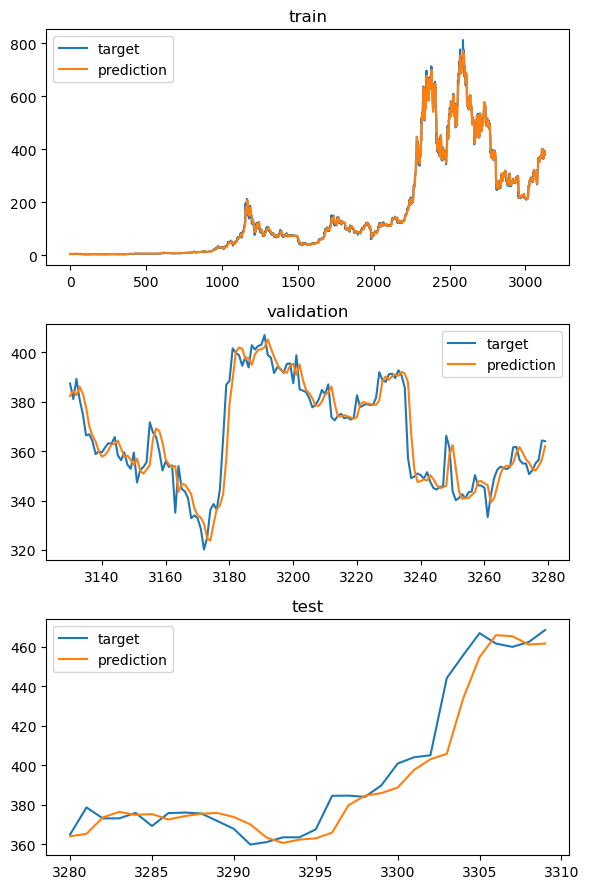

In [1]:
import torch
import wandb
from matplotlib import pyplot as plt
from datetime import datetime
import os
from pathlib import Path


BASE_PATH = str(Path().resolve().parent.parent) 
import sys
sys.path.append(BASE_PATH)

CURRENT_FILE_PATH = os.getcwd()
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")
if not os.path.isdir(CHECKPOINT_FILE_PATH):
  os.makedirs(os.path.join(CURRENT_FILE_PATH, "checkpoints"))

from f_arg_parser import get_parser
from p__cryptocurrency_dataset_dataloader import get_cryptocurrency_data, \
  CryptoCurrencyDataset
from g_crypto_currency_regression_train_lstm import get_model, get_btc_krw_data


def test(test_model):
  _, _, test_data_loader = get_btc_krw_data()

  test_model.eval()

  y_normalizer = 100

  print("[TEST DATA]")
  with torch.no_grad():
    for test_batch in test_data_loader:
      input_test, target_test = test_batch

      output_test = test_model(input_test)

    for idx, (output, target) in enumerate(zip(output_test, target_test)):
      print("{0:2}: {1:6,.2f} <--> {2:6,.2f} (Loss: {3:>13,.2f})".format(
        idx,
        output.item() * y_normalizer,
        target.item() * y_normalizer,
        abs(output.squeeze(dim=-1).item() - target.item()) * y_normalizer
      ))


def predict_all(test_model):
  y_normalizer = 100

  X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date \
    = get_cryptocurrency_data(
      sequence_size=21, validation_size=150, test_size=30,
      target_column='Close', y_normalizer=1.0e7, is_regression=True
  )

  train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train)
  validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation)
  test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test)

  dataset_list = [
    train_crypto_currency_dataset, validation_crypto_currency_dataset, test_crypto_currency_dataset
  ]
  dataset_labels = [
    "train", "validation", "test"
  ]
  num = 0
  fig, axs = plt.subplots(3, 1, figsize=(6, 9))

  for i in range(3):
    X = []
    TARGET_Y = []
    PREDICTION_Y = []
    for data in dataset_list[i]:
      input, target = data
      prediction = test_model(input.unsqueeze(0)).squeeze(-1).squeeze(-1)

      X.append(num)
      TARGET_Y.append(target.item() * y_normalizer)
      PREDICTION_Y.append(prediction.item() * y_normalizer)

      num += 1

    axs[i].plot(X, TARGET_Y, label='target')
    axs[i].plot(X, PREDICTION_Y, label='prediction')
    axs[i].set_title(dataset_labels[i])
    axs[i].legend()

  plt.tight_layout()
  plt.show()


def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,
    'early_stop_patience': args.early_stop_patience,
    'early_stop_delta': args.early_stop_delta,
  }

  project_name = "lstm_regression_btc_krw"
  wandb.init(
    mode="disabled",
    project=project_name,
    notes="btc_krw experiment with lstm",
    tags=["lstm", "regression", "btc_krw"],
    name=run_time_str,
    config=config
  )

  test_model = get_model()

  project_name = "lstm_regression_btc_krw"
  latest_file_path = os.path.join(
    CHECKPOINT_FILE_PATH, f"{project_name}_checkpoint_latest.pt"
  )
  print("MODEL FILE: {0}".format(latest_file_path))
  test_model.load_state_dict(torch.load(latest_file_path, map_location=torch.device('cpu')))

  test(test_model)
  predict_all(test_model)


if __name__ == "__main__":
  parser = get_parser()
  args = parser.parse_args([])
  main(args)

문제 2에서는 다음과 같이 loss가 분포되었다.
최대 : 39.11
최소 : 0.30
평균 : 6.87
표준편차: : 8.17

문제 3에서는 다음과 같이 loss가 분포되었다.
최대 : 38.34
최소 : 0.13
평균 : 6.67
표준편차 : 7.90

문제 3에서 평균과 표준편차가 소폭 감소하였다.

문제3-2
next_open 추가 관련 classification 비교

In [2]:
import torch
from torch import nn, optim
from datetime import datetime
import os
import wandb
from pathlib import Path

BASE_PATH = str(Path().resolve().parent.parent) 
import sys
sys.path.append(BASE_PATH)

CURRENT_FILE_PATH = os.getcwd()
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")

if not os.path.isdir(CHECKPOINT_FILE_PATH):
  os.makedirs(os.path.join(CURRENT_FILE_PATH, "checkpoints"))

from c_trainer import ClassificationTrainer
from f_arg_parser import get_parser
from g_crypto_currency_regression_train_lstm import get_btc_krw_data


def get_model():
  class MyModel(nn.Module):
    def __init__(self, n_input, n_output):
      super().__init__()

      self.lstm = nn.LSTM(input_size=n_input, hidden_size=256, num_layers=3, batch_first=True, dropout=0.1)
      self.fcn = nn.Linear(in_features=256, out_features=n_output)

    def forward(self, x):
      x, hidden = self.lstm(x)
      x = x[:, -1, :]  
      x = self.fcn(x)
      return x

  my_model = MyModel(n_input=6, n_output=2)

  return my_model


def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,
    'early_stop_patience': args.early_stop_patience,
    'early_stop_delta': args.early_stop_delta,
    'weight_decay': args.weight_decay
  }

  project_name = "lstm_classification_btc_krw"
  wandb.init(
    mode="online",
    project=project_name,
    notes="btc_krw experiment with lstm",
    tags=["lstm", "classification", "btc_krw"],
    name=run_time_str,
    config=config
  )
  print(args)
  print(wandb.config)

  train_data_loader, validation_data_loader, _ = get_btc_krw_data(is_regression=False)
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  print(f"Training on device {device}.")

  model = get_model()
  model.to(device)

  optimizer = optim.Adam(model.parameters(), lr=wandb.config.learning_rate, weight_decay=0)

  classification_trainer = ClassificationTrainer(
    project_name, model, optimizer, train_data_loader, validation_data_loader, None,
    run_time_str, wandb, device, CHECKPOINT_FILE_PATH
  )
  classification_trainer.train_loop()

  wandb.finish()


if __name__ == "__main__":
  parser = get_parser()
  args = parser.parse_args([])
  main(args)

Namespace(wandb=True, batch_size=2048, epochs=10000, learning_rate=0.0001, weight_decay=0, validation_intervals=30, early_stop_patience=30, early_stop_delta=1e-06)
{'epochs': 10000, 'batch_size': 2048, 'validation_intervals': 30, 'learning_rate': 0.0001, 'early_stop_patience': 30, 'early_stop_delta': 1e-06, 'weight_decay': 0}
Training on device cuda:0.
[Epoch   1] T_loss: 0.69301, T_accuracy: 49.2013 | V_loss: 0.69354, V_accuracy: 47.3333 | Early stopping is stated! | T_time: 00:00:00, T_speed: 0.000
[Epoch  30] T_loss: 0.68985, T_accuracy: 53.4505 | V_loss: 0.69393, V_accuracy: 47.3333 | Early stopping counter: 1 out of 30 | T_time: 00:00:03, T_speed: 10.000
[Epoch  60] T_loss: 0.69060, T_accuracy: 53.1949 | V_loss: 0.69338, V_accuracy: 47.3333 | V_loss decreased (0.69354 --> 0.69338). Saving model... | T_time: 00:00:06, T_speed: 10.000
[Epoch  90] T_loss: 0.69015, T_accuracy: 53.2588 | V_loss: 0.69364, V_accuracy: 47.3333 | Early stopping counter: 1 out of 30 | T_time: 00:00:09, T_sp

Epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
Training accuracy (%),▁▃▃▃▃▄▄▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇██▇███
Training loss,██████████▇▇▇▇▇▇▆▆▅▅▅▅▄▄▄▃▃▃▃▃▃▂▂▂▃▂▂▂▁▁
Training speed (epochs/sec.),▁███████████████████████████████████████
Validation accuracy (%),▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂█▄▇▂▅▂▂▂▂▂▂▁▂▂▂▂▂▂▄▂▁▂▂
Validation loss,▁▂▁▁▂▂▂▂▃▂▁▂▂▁▁▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▃▃▂▃▂▃▅█▇
Epoch,1680
Training accuracy (%),61.3099
Training loss,0.58997
Training speed (epochs/sec.),9.38547
Validation accuracy (%),47.33333


In [3]:
import torch
import os
from pathlib import Path
from datetime import datetime
import wandb


BASE_PATH = str(Path().resolve().parent.parent) 
import sys
sys.path.append(BASE_PATH)

CURRENT_FILE_PATH = os.getcwd()
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")

if not os.path.isdir(CHECKPOINT_FILE_PATH):
  os.makedirs(os.path.join(CURRENT_FILE_PATH, "checkpoints"))

from f_arg_parser import get_parser
from g_crypto_currency_regression_train_lstm import get_btc_krw_data
from i_crypto_currency_classification_train_lstm import get_model


def test(test_model):
  _, _, test_data_loader = get_btc_krw_data(is_regression=False)

  test_model.eval()

  num_corrects_test = 0
  num_tested_samples = 0

  print("[TEST DATA]")
  with torch.no_grad():
    for test_batch in test_data_loader:
      input_test, target_test = test_batch

      output_test = test_model(input_test)

      predicted_test = torch.argmax(output_test, dim=1)
      num_corrects_test += torch.sum(torch.eq(predicted_test, target_test))

      num_tested_samples += len(input_test)

    test_accuracy = 100.0 * num_corrects_test / num_tested_samples

    print(f"TEST RESULTS: {test_accuracy:6.3f}%")

    for idx, (output, target) in enumerate(zip(output_test, target_test)):
      print("{0:2}: {1:6,.2f} <--> {2:6,.2f}".format(
        idx, torch.argmax(output).item(), target.item()
      ))


def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,
    'early_stop_patience': args.early_stop_patience,
    'early_stop_delta': args.early_stop_delta,
  }

  project_name = "lstm_classification_btc_krw"
  wandb.init(
    mode="disabled",
    project=project_name,
    notes="btc_krw experiment with lstm",
    tags=["lstm", "regression", "btc_krw"],
    name=run_time_str,
    config=config
  )

  test_model = get_model()

  latest_file_path = os.path.join(
    CHECKPOINT_FILE_PATH, f"{project_name}_checkpoint_latest.pt"
  )
  print("MODEL FILE: {0}".format(latest_file_path))
  test_model.load_state_dict(torch.load(latest_file_path, map_location=torch.device('cpu')))

  test(test_model)


if __name__ == "__main__":
  parser = get_parser()
  args = parser.parse_args([])
  main(args)


MODEL FILE: /home/kroad/Downloads/git/link_dl/_04_your_code/checkpoints/lstm_classification_btc_krw_checkpoint_latest.pt


/tmp/ipykernel_186194/1361066133.py:81: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_model.load_state_dict(torch.load(latest_file_path, map_location=torch.device('cpu'

[TEST DATA]
TEST RESULTS: 33.333%
 0:   0.00 <-->   0.00
 1:   0.00 <-->   0.00
 2:   0.00 <-->   0.00
 3:   0.00 <-->   1.00
 4:   0.00 <-->   1.00
 5:   0.00 <-->   1.00
 6:   0.00 <-->   1.00
 7:   0.00 <-->   0.00
 8:   0.00 <-->   1.00
 9:   0.00 <-->   1.00
10:   0.00 <-->   0.00
11:   0.00 <-->   1.00
12:   0.00 <-->   0.00
13:   0.00 <-->   0.00
14:   0.00 <-->   1.00
15:   0.00 <-->   1.00
16:   0.00 <-->   1.00
17:   0.00 <-->   1.00
18:   0.00 <-->   1.00
19:   0.00 <-->   1.00
20:   0.00 <-->   0.00
21:   0.00 <-->   1.00
22:   0.00 <-->   1.00
23:   0.00 <-->   1.00
24:   0.00 <-->   1.00
25:   0.00 <-->   1.00
26:   0.00 <-->   1.00
27:   0.00 <-->   1.00
28:   0.00 <-->   0.00
29:   0.00 <-->   0.00


문제 2에서는 Training accuracy가 60.8%, Validation accuracy가 48.6%였다.
문제 3에서는 Training accuracy는 소폭 상승한 61.3%, Validation accuracy는 소폭 감소한 47.3%가 나왔다.

TEST RESULTS의 경우 60.0%에서 33.3%로 크게 하락하였다.

문제4-1
self-attention 적용 시 regression 비교

In [4]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from datetime import datetime
import os
import wandb
from pathlib import Path

BASE_PATH = str(Path().resolve().parent.parent)
import sys
sys.path.append(BASE_PATH)

CURRENT_FILE_PATH = os.getcwd()
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")
if not os.path.isdir(CHECKPOINT_FILE_PATH):
  os.makedirs(os.path.join(CURRENT_FILE_PATH, "checkpoints"))

from f_arg_parser import get_parser
from g_rnn_trainer import RegressionTrainer
from p__cryptocurrency_dataset_dataloader import (
  get_cryptocurrency_data,
  CryptoCurrencyDataset,
)

def get_btc_krw_data(sequence_size=21, validation_size=150, test_size=30, is_regression=True):
  X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date \
    = get_cryptocurrency_data(
      sequence_size=sequence_size, validation_size=validation_size, test_size=test_size,
      target_column='Close', y_normalizer=1.0e7, is_regression=is_regression
  )

  train_dataset = CryptoCurrencyDataset(X=X_train, y=y_train)
  val_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation)
  test_dataset = CryptoCurrencyDataset(X=X_test, y=y_test)

  train_loader = DataLoader(dataset=train_dataset, batch_size=wandb.config.batch_size, shuffle=True)
  val_loader = DataLoader(dataset=val_dataset, batch_size=wandb.config.batch_size, shuffle=True)
  test_loader = DataLoader(dataset=test_dataset, batch_size=len(test_dataset), shuffle=True)

  return train_loader, val_loader, test_loader


class PositionalEncoding(nn.Module):
  def __init__(self, d_model: int, max_len: int = 512):
    super().__init__()
    pe = torch.zeros(max_len, d_model)  
    position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)  
    div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    pe = pe.unsqueeze(0)  
    self.register_buffer("pe", pe)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    T = x.size(1)
    return x + self.pe[:, :T, :]


def get_model():
  class MyModel(nn.Module):
    def __init__(
      self,
      n_input: int,
      n_output: int,
      embed_dim: int = 256,
      num_heads: int = 8,
      num_layers: int = 3,
      ff_dim: int = 512,
      dropout: float = 0.1,
      max_len: int = 512,
    ):
      super().__init__()

      self.input_proj = nn.Linear(n_input, embed_dim)
      self.pos_enc = PositionalEncoding(d_model=embed_dim, max_len=max_len)

      encoder_layer = nn.TransformerEncoderLayer(
        d_model=embed_dim,
        nhead=num_heads,
        dim_feedforward=ff_dim,
        dropout=dropout,
        batch_first=True,
        activation="gelu",
        norm_first=True,
      )
      self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
      self.final_norm = nn.LayerNorm(embed_dim)

      self.head = nn.Linear(embed_dim, n_output)

    def forward(self, x):
      x = self.input_proj(x)          
      x = self.pos_enc(x)             
      x = self.encoder(x)            
      x = x[:, -1, :]             
      x = self.final_norm(x)         
      x = self.head(x)                
      return x

  return MyModel(n_input=6, n_output=1)


def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,
    'early_stop_patience': args.early_stop_patience,
    'early_stop_delta': args.early_stop_delta,
    'weight_decay': args.weight_decay,
  }

  project_name = "attn_regression_btc_krw"
  wandb.init(
    mode="online",
    project=project_name,
    notes="btc_krw experiment with self-attention (transformer encoder)",
    tags=["self-attention", "transformer", "regression", "btc_krw"],
    name=run_time_str,
    config=config
  )
  print(args)
  print(wandb.config)

  train_loader, val_loader, _ = get_btc_krw_data()
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  print(f"Training on device {device}.")

  model = get_model().to(device)
  optimizer = optim.Adam(model.parameters(), lr=wandb.config.learning_rate, weight_decay=wandb.config.weight_decay)

  regression_trainer = RegressionTrainer(
    project_name, model, optimizer, train_loader, val_loader, None,
    run_time_str, wandb, device, CHECKPOINT_FILE_PATH
  )
  regression_trainer.train_loop()

  wandb.finish()


if __name__ == "__main__":
  parser = get_parser()
  args = parser.parse_args([])
  main(args)


Namespace(wandb=True, batch_size=2048, epochs=10000, learning_rate=0.0001, weight_decay=0, validation_intervals=30, early_stop_patience=30, early_stop_delta=1e-06)
{'epochs': 10000, 'batch_size': 2048, 'validation_intervals': 30, 'learning_rate': 0.0001, 'early_stop_patience': 30, 'early_stop_delta': 1e-06, 'weight_decay': 0}
Training on device cuda:0.


/home/kroad/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


[Epoch   1] T_loss: 4.46843, V_loss: 2.30334, Early stopping is stated! | T_time: 00:00:00, T_speed: 0.000
[Epoch  30] T_loss: 0.05460, V_loss: 0.01695, V_loss decreased (2.30334 --> 0.01695). Saving model... | T_time: 00:00:06, T_speed: 5.000
[Epoch  60] T_loss: 0.03150, V_loss: 0.00942, V_loss decreased (0.01695 --> 0.00942). Saving model... | T_time: 00:00:13, T_speed: 4.615
[Epoch  90] T_loss: 0.02900, V_loss: 0.00774, V_loss decreased (0.00942 --> 0.00774). Saving model... | T_time: 00:00:20, T_speed: 4.500
[Epoch 120] T_loss: 0.02325, V_loss: 0.00621, V_loss decreased (0.00774 --> 0.00621). Saving model... | T_time: 00:00:26, T_speed: 4.615
[Epoch 150] T_loss: 0.02092, V_loss: 0.00564, V_loss decreased (0.00621 --> 0.00564). Saving model... | T_time: 00:00:33, T_speed: 4.545
[Epoch 180] T_loss: 0.01928, V_loss: 0.00580, Early stopping counter: 1 out of 30 | T_time: 00:00:40, T_speed: 4.500
[Epoch 210] T_loss: 0.01928, V_loss: 0.00575, Early stopping counter: 2 out of 30 | T_time:

Epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇██
Training loss,█▅▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training speed (epochs/sec.),█▃█▄▆▅▄▃▃▄▂▃▂▂▃▂▁▁▂▂▁▁▂▁▁▁▁▁▁▁▂▂▂▂▂▂▂▃▂▂
Validation loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,2040
Training loss,0.00722
Training speed (epochs/sec.),4.47368
Validation loss,0.01298


/home/kroad/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/tmp/ipykernel_194582/1523078240.py:116: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torc

MODEL FILE: /home/kroad/Downloads/git/link_dl/_04_your_code/checkpoints/attn_regression_btc_krw_checkpoint_latest.pt
[TEST DATA]
 0: 368.83 <--> 359.80 (Loss:          9.04)
 1: 367.22 <--> 384.49 (Loss:         17.27)
 2: 385.50 <--> 383.94 (Loss:          1.56)
 3: 470.37 <--> 459.89 (Loss:         10.48)
 4: 364.59 <--> 364.86 (Loss:          0.27)
 5: 467.74 <--> 462.33 (Loss:          5.41)
 6: 448.66 <--> 455.68 (Loss:          7.02)
 7: 468.10 <--> 468.41 (Loss:          0.32)
 8: 378.30 <--> 373.05 (Loss:          5.24)
 9: 385.85 <--> 389.72 (Loss:          3.86)
10: 365.15 <--> 363.46 (Loss:          1.70)
11: 361.59 <--> 361.07 (Loss:          0.52)
12: 404.52 <--> 405.02 (Loss:          0.50)
13: 373.17 <--> 375.84 (Loss:          2.67)
14: 375.55 <--> 369.19 (Loss:          6.36)
15: 375.97 <--> 375.55 (Loss:          0.42)
16: 373.46 <--> 367.74 (Loss:          5.72)
17: 362.85 <--> 367.49 (Loss:          4.64)
18: 387.95 <--> 384.58 (Loss:          3.37)
19: 406.26 <--> 

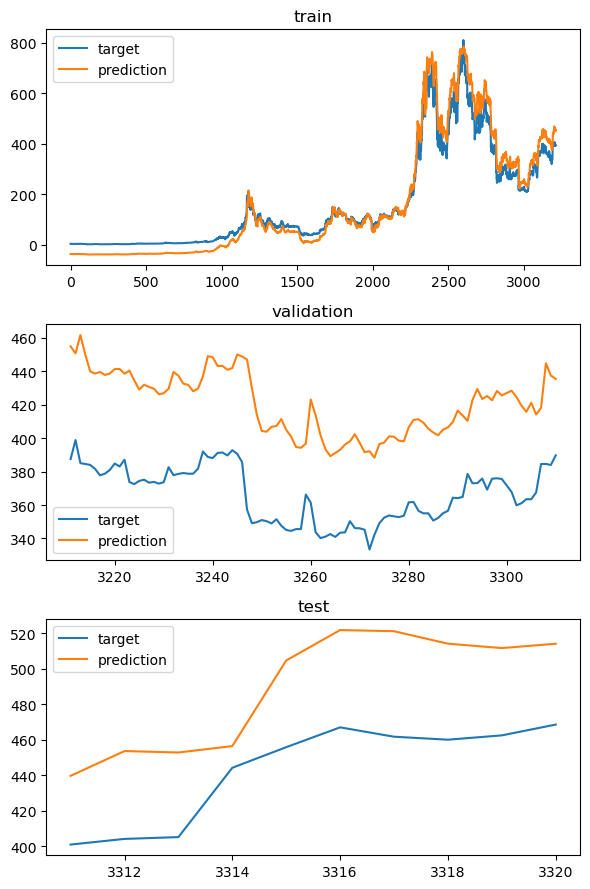

In [2]:
import torch
import wandb
from matplotlib import pyplot as plt
from datetime import datetime
import os
from pathlib import Path

BASE_PATH = str(Path().resolve().parent.parent)
import sys
sys.path.append(BASE_PATH)

CURRENT_FILE_PATH = os.getcwd()
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")
if not os.path.isdir(CHECKPOINT_FILE_PATH):
  os.makedirs(os.path.join(CURRENT_FILE_PATH, "checkpoints"))

from f_arg_parser import get_parser
from p__cryptocurrency_dataset_dataloader import (
  get_cryptocurrency_data,
  CryptoCurrencyDataset
)
from g_crypto_currency_regression_train_attention import get_model, get_btc_krw_data


def test(test_model):
  _, _, test_loader = get_btc_krw_data()
  test_model.eval()

  y_normalizer = 100

  print("[TEST DATA]")
  with torch.no_grad():
    for test_batch in test_loader:
      input_test, target_test = test_batch
      output_test = test_model(input_test)

    for idx, (output, target) in enumerate(zip(output_test, target_test)):
      print("{0:2}: {1:6,.2f} <--> {2:6,.2f} (Loss: {3:>13,.2f})".format(
        idx,
        output.item() * y_normalizer,
        target.item() * y_normalizer,
        abs(output.squeeze(dim=-1).item() - target.item()) * y_normalizer
      ))


def predict_all(test_model):
  y_normalizer = 100

  X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date \
    = get_cryptocurrency_data(
      sequence_size=10, validation_size=100, test_size=10,
      target_column='Close', y_normalizer=1.0e7, is_regression=True
  )

  train_dataset = CryptoCurrencyDataset(X=X_train, y=y_train)
  val_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation)
  test_dataset = CryptoCurrencyDataset(X=X_test, y=y_test)

  dataset_list = [train_dataset, val_dataset, test_dataset]
  dataset_labels = ["train", "validation", "test"]

  num = 0
  fig, axs = plt.subplots(3, 1, figsize=(6, 9))

  test_model.eval()
  with torch.no_grad():
    for i in range(3):
      X = []
      TARGET_Y = []
      PRED_Y = []

      for data in dataset_list[i]:
        input_x, target = data
        pred = test_model(input_x.unsqueeze(0)).squeeze(-1).squeeze(-1)

        X.append(num)
        TARGET_Y.append(target.item() * y_normalizer)
        PRED_Y.append(pred.item() * y_normalizer)
        num += 1

      axs[i].plot(X, TARGET_Y, label='target')
      axs[i].plot(X, PRED_Y, label='prediction')
      axs[i].set_title(dataset_labels[i])
      axs[i].legend()

  plt.tight_layout()
  plt.show()


def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,
    'early_stop_patience': args.early_stop_patience,
    'early_stop_delta': args.early_stop_delta,
  }

  project_name = "attn_regression_btc_krw"
  wandb.init(
    mode="disabled",
    project=project_name,
    notes="btc_krw experiment with self-attention (transformer encoder)",
    tags=["self-attention", "transformer", "regression", "btc_krw"],
    name=run_time_str,
    config=config
  )

  test_model = get_model()

  latest_file_path = os.path.join(CHECKPOINT_FILE_PATH, f"{project_name}_checkpoint_latest.pt")
  print("MODEL FILE: {0}".format(latest_file_path))
  test_model.load_state_dict(torch.load(latest_file_path, map_location=torch.device('cpu')))

  test(test_model)
  predict_all(test_model)


if __name__ == "__main__":
  parser = get_parser()
  args = parser.parse_args([])
  main(args)


문제 3에서는 다음과 같이 loss가 분포되었다.
최대 : 38.34
최소 : 0.13
평균 : 6.67
표준편차 : 7.90

문제 4에서는 다음과 같이 loss가 분포되었다.
최대 : 37.82
최소 : 0.27
평균 : 5.99
표준편차 : 7.29

문제 4가 문제 3에비해 평균과 표준편차가 소폭 감소하였다.

문제4-2
self-attention 적용 시 classification 비교

In [ ]:
import torch
from torch import nn, optim
from datetime import datetime
import os
import wandb
from pathlib import Path

BASE_PATH = str(Path().resolve().parent.parent)
import sys
sys.path.append(BASE_PATH)

CURRENT_FILE_PATH = os.getcwd()
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")
if not os.path.isdir(CHECKPOINT_FILE_PATH):
  os.makedirs(os.path.join(CURRENT_FILE_PATH, "checkpoints"))

from c_trainer import ClassificationTrainer
from f_arg_parser import get_parser
from g_crypto_currency_regression_train_attention import get_btc_krw_data


class PositionalEncoding(nn.Module):
  def __init__(self, d_model: int, max_len: int = 512):
    super().__init__()
    pe = torch.zeros(max_len, d_model)
    position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    pe = pe.unsqueeze(0)
    self.register_buffer("pe", pe)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    T = x.size(1)
    return x + self.pe[:, :T, :]


def get_model():
  class MyModel(nn.Module):
    def __init__(
      self,
      n_input: int,
      n_output: int,
      embed_dim: int = 256,
      num_heads: int = 8,
      num_layers: int = 3,
      ff_dim: int = 512,
      dropout: float = 0.1,
      max_len: int = 512,
    ):
      super().__init__()
      self.input_proj = nn.Linear(n_input, embed_dim)
      self.pos_enc = PositionalEncoding(d_model=embed_dim, max_len=max_len)

      encoder_layer = nn.TransformerEncoderLayer(
        d_model=embed_dim,
        nhead=num_heads,
        dim_feedforward=ff_dim,
        dropout=dropout,
        batch_first=True,
        activation="gelu",
        norm_first=True,
      )
      self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
      self.final_norm = nn.LayerNorm(embed_dim)

      self.head = nn.Linear(embed_dim, n_output)

    def forward(self, x):
      x = self.input_proj(x)
      x = self.pos_enc(x)
      x = self.encoder(x)
      x = x[:, -1, :]
      x = self.final_norm(x)
      x = self.head(x)   
      return x

  return MyModel(n_input=6, n_output=2)


def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,
    'early_stop_patience': args.early_stop_patience,
    'early_stop_delta': args.early_stop_delta,
    'weight_decay': args.weight_decay
  }

  project_name = "attn_classification_btc_krw"
  wandb.init(
    mode="online",
    project=project_name,
    notes="btc_krw experiment with self-attention (transformer encoder)",
    tags=["self-attention", "transformer", "classification", "btc_krw"],
    name=run_time_str,
    config=config
  )
  print(args)
  print(wandb.config)

  train_loader, val_loader, _ = get_btc_krw_data(is_regression=False)
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  print(f"Training on device {device}.")

  model = get_model().to(device)
  optimizer = optim.Adam(model.parameters(), lr=wandb.config.learning_rate, weight_decay=wandb.config.weight_decay)

  trainer = ClassificationTrainer(
    project_name, model, optimizer, train_loader, val_loader, None,
    run_time_str, wandb, device, CHECKPOINT_FILE_PATH
  )
  trainer.train_loop()

  wandb.finish()


if __name__ == "__main__":
  parser = get_parser()
  args = parser.parse_args([])
  main(args)


Namespace(wandb=True, batch_size=2048, epochs=10000, learning_rate=0.0001, weight_decay=0, validation_intervals=30, early_stop_patience=30, early_stop_delta=1e-06)
{'epochs': 10000, 'batch_size': 2048, 'validation_intervals': 30, 'learning_rate': 0.0001, 'early_stop_patience': 30, 'early_stop_delta': 1e-06, 'weight_decay': 0}
Training on device cuda:0.


/home/kroad/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


[Epoch   1] T_loss: 0.73792, T_accuracy: 50.7987 | V_loss: 0.70488, V_accuracy: 47.3333 | Early stopping is stated! | T_time: 00:00:00, T_speed: 0.000
[Epoch  30] T_loss: 0.69232, T_accuracy: 52.9073 | V_loss: 0.69577, V_accuracy: 47.3333 | V_loss decreased (0.70488 --> 0.69577). Saving model... | T_time: 00:00:06, T_speed: 5.000
[Epoch  60] T_loss: 0.69168, T_accuracy: 53.3227 | V_loss: 0.69336, V_accuracy: 49.3333 | V_loss decreased (0.69577 --> 0.69336). Saving model... | T_time: 00:00:13, T_speed: 4.615
[Epoch  90] T_loss: 0.69312, T_accuracy: 53.2588 | V_loss: 0.69174, V_accuracy: 53.3333 | V_loss decreased (0.69336 --> 0.69174). Saving model... | T_time: 00:00:19, T_speed: 4.737
[Epoch 120] T_loss: 0.68991, T_accuracy: 53.9297 | V_loss: 0.69651, V_accuracy: 46.6667 | Early stopping counter: 1 out of 30 | T_time: 00:00:26, T_speed: 4.615
[Epoch 150] T_loss: 0.68607, T_accuracy: 54.9201 | V_loss: 0.68649, V_accuracy: 56.6667 | V_loss decreased (0.69174 --> 0.68649). Saving model...

Epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
Training accuracy (%),▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇████
Training loss,█▇▇▇▇▇▇▇▇▇▆▆▆▆▅▅▅▄▄▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁
Training speed (epochs/sec.),▁█▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
Validation accuracy (%),▂▂▃▆▂█▆▅▅▃▃▄▅▄▄▂▁▃▃█▃▄▃▇▆█▇▆▆▆▆▅█▅▆▆▅
Validation loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▂▃▄▄▄▅▅▅▇▇▇▇▇▇█▇██
Epoch,1080
Training accuracy (%),77.02875
Training loss,0.38007
Training speed (epochs/sec.),4.44444
Validation accuracy (%),51.33333


In [ ]:
import torch
import os
from pathlib import Path
from datetime import datetime
import wandb

BASE_PATH = str(Path().resolve().parent.parent)
import sys
sys.path.append(BASE_PATH)

CURRENT_FILE_PATH = os.getcwd()
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")
if not os.path.isdir(CHECKPOINT_FILE_PATH):
  os.makedirs(os.path.join(CURRENT_FILE_PATH, "checkpoints"))

from f_arg_parser import get_parser
from g_crypto_currency_regression_train_attention import get_btc_krw_data
from i_crypto_currency_classification_train_attention import get_model


def test(test_model):
  _, _, test_loader = get_btc_krw_data(is_regression=False)
  test_model.eval()

  num_corrects_test = 0
  num_tested_samples = 0

  print("[TEST DATA]")
  with torch.no_grad():
    for test_batch in test_loader:
      input_test, target_test = test_batch

      output_test = test_model(input_test)
      predicted_test = torch.argmax(output_test, dim=1)

      num_corrects_test += torch.sum(torch.eq(predicted_test, target_test))
      num_tested_samples += len(input_test)

    test_accuracy = 100.0 * num_corrects_test / num_tested_samples
    print(f"TEST RESULTS: {test_accuracy:6.3f}%")

    for idx, (output, target) in enumerate(zip(output_test, target_test)):
      print("{0:2}: {1:6,.2f} <--> {2:6,.2f}".format(
        idx, torch.argmax(output).item(), target.item()
      ))


def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,
    'early_stop_patience': args.early_stop_patience,
    'early_stop_delta': args.early_stop_delta,
  }

  project_name = "attn_classification_btc_krw"
  wandb.init(
    mode="disabled",
    project=project_name,
    notes="btc_krw experiment with self-attention (transformer encoder)",
    tags=["self-attention", "transformer", "classification", "btc_krw"],
    name=run_time_str,
    config=config
  )

  test_model = get_model()

  latest_file_path = os.path.join(CHECKPOINT_FILE_PATH, f"{project_name}_checkpoint_latest.pt")
  print("MODEL FILE: {0}".format(latest_file_path))
  test_model.load_state_dict(torch.load(latest_file_path, map_location=torch.device('cpu')))

  test(test_model)


if __name__ == "__main__":
  parser = get_parser()
  args = parser.parse_args([])
  main(args)


/home/kroad/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/tmp/ipykernel_198879/2176199353.py:75: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch

MODEL FILE: /home/kroad/Downloads/git/link_dl/_04_your_code/checkpoints/attn_classification_btc_krw_checkpoint_latest.pt
[TEST DATA]
TEST RESULTS: 36.667%
 0:   1.00 <-->   1.00
 1:   0.00 <-->   1.00
 2:   0.00 <-->   1.00
 3:   0.00 <-->   1.00
 4:   0.00 <-->   1.00
 5:   0.00 <-->   1.00
 6:   0.00 <-->   1.00
 7:   0.00 <-->   1.00
 8:   0.00 <-->   0.00
 9:   0.00 <-->   1.00
10:   1.00 <-->   0.00
11:   0.00 <-->   1.00
12:   0.00 <-->   1.00
13:   0.00 <-->   0.00
14:   0.00 <-->   1.00
15:   1.00 <-->   0.00
16:   0.00 <-->   1.00
17:   0.00 <-->   0.00
18:   0.00 <-->   1.00
19:   0.00 <-->   0.00
20:   0.00 <-->   1.00
21:   0.00 <-->   0.00
22:   1.00 <-->   1.00
23:   0.00 <-->   0.00
24:   0.00 <-->   1.00
25:   0.00 <-->   0.00
26:   0.00 <-->   1.00
27:   1.00 <-->   1.00
28:   0.00 <-->   0.00
29:   0.00 <-->   1.00


문제 3에서는 Training accuracy는 소폭 상승한 61.3%, Validation accuracy는 소폭 감소한 47.3%가 나왔다.
문제 4에서는 각각 77.0%, 51.3%로 개선되었다.

TEST RESULTS는 33.3%에서 36.6%로 소폭 상승했다.

숙제 후기
이번 숙제를 통해 lstm과 self-attention을 통한 시계열 데이터 학습에 대해 배울 수 있었다.
또한 파라미터를 변경해가며 결과가 달라지는 것을 확인하며 파라미터를 조절하는 것에 익숙해질 수 있었다.